# Gaussian Process Regression

This demo shows how to use the GaussianProcessRegressor class to calculate the efficiency of three-jet events with MET < 50 GeV. Derivatives are used to 
enhance the regression.

The following nuisance parameters are considered:
- $\nu_{J1}$: Jet energy scale of the leading jet, $J_1$.
- $\nu_{J23}$: Jet energy scale of the two softer jets, $J_2$ and $J_3$.

In [1]:
# Imports
import gpder
from gpder.gaussian_process import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel, DerivativeKernel

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, Arrow, FancyArrow
%matplotlib inline  

from multiprocessing import Pool, cpu_count

In [2]:
from utils import download_dataset, load_dataset

# Downloading the dataset from zenodo. 
# By default, the h5df file is saved in the current directory.
download_dataset()
threeM = load_dataset()

# The dataset consists of 30000 events, each with three jets. 
# For each jet, the three-momenta (pT, eta, phi) are saved in descending pT-order.
print("Shape of the dataset:", threeM.shape)

Shape of the dataset: (30000, 3, 3)


Title: Estimation of Unfactorizable Systematic Uncertainties
Keywords: 
Publication date: 2024-04-14
DOI: 10.5281/zenodo.10971439
Total size: 1.0 MB

Link: https://zenodo.org/api/records/10971439/files/three_jets_30k.h5/content   size: 1.0 MB
three_jets_30k.h5 is already downloaded correctly.
All files have been downloaded.


In [3]:
# Plotting function
from utils import plot_regression

# Function that calculates the efficiency with respect to the two nuisance
# See hep_functions.py for more details
from hep_functions import efficiency
def efficiency_events(X):
    # Simplifying the input
    return efficiency(X, threeM)

# And the function that calculates the gradient of the efficiency
# To improve numerical stability, we smooth out the gradients by setting the
# parameter a=1/10
from hep_functions import der_efficiency
def der_efficiency_events_sigmoid10(X, threeM=threeM):
    # Simplifying the input
    return der_efficiency(X, threeM, a=1/10)


In [4]:
# -- Test dataset ---------------------------------------------------------- #
res_test = 25
X_lower, X_upper = 0.5, 1.5
lin = np.linspace(X_lower, X_upper, res_test)
nu_J1_test, nu_J23_test = np.meshgrid(lin, lin)
X_test = np.array([nu_J1_test.flatten(), nu_J23_test.flatten()]).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)
dX_test = X_test
dy_test = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_test)
dy_test = np.array(dy_test).reshape(-1, 2)
# -------------------------------------------------------------------------- #

# -- Trainning dataset ----------------------------------------------------- #
nu_J1_train = [0.74, 1.0, 1.0, 1.0, 1.25]
nu_J23_train = [1.0, 0.75, 1.0, 1.25, 1.0]
X_train = np.array([nu_J1_train, nu_J23_train]).T
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train)
dX_train = X_train
dy_train = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_train)
dy_train = np.array(dy_train).reshape(-1, 2)
# -------------------------------------------------------------------------- #

Kernel before optimization: 
1**2 * DerivativeRBF(length_scale=0.1) + WhiteKernel(noise_level=0.1) + WhiteKernel_der(noise_level=0.1)


/home/alex/mambaforge/envs/gpder/lib/python3.11/site-packages/gpder/gaussian_process/gaussian_process.py:913: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", res)



Kernel after optimization: 
0.488**2 * DerivativeRBF(length_scale=0.27) + WhiteKernel(noise_level=0.109) + WhiteKernel_der(noise_level=0.01)

Evaluation 
MSE:  0.07956695862796641
Net variance:  25.589993965965


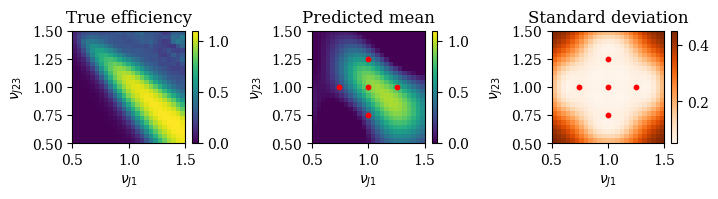

In [5]:
# -- Fitting the model and hyperparameter optimization --------------------- #
# Optional: we can make the length scale anisotropic by setting
# length_scale=[0.1, 0.1], for example. Same with noise_level_der.
kernel = DerivativeKernel(
    amplitude=1.0, length_scale=0.1, noise_level=0.1, noise_level_der=0.1
)
print("Kernel before optimization: ")
print(kernel)
# Set optimizer=None to skip hyperparameter optimization
gp = GaussianProcessRegressor(
    kernel=kernel, optimizer="L-BFGS-B", n_restarts_optimizer=10, random_state=42
)
gp.fit(X_train, y_train, X_train, dy_train)
print("\nKernel after optimization: ")
print(gp.kernel)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

print("\nEvaluation ")
n_test = len(y_test)
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / n_test
print("MSE: ", mse)
print("Net variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #

plot_regression(gp, X_test, y_test)

## Predicting the gradients 

We can utilize the GP model to predict the gradients themselves.

Shape of gradient prediction:  (1250, 1)

Evaluation 
MSE:  1.0385587841455255
Net variance:  641.2104894181831


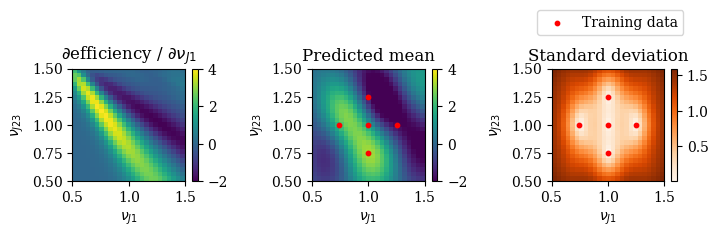

In [6]:
# -- Predicting the gradients with respect to the first derivative --------- #
# The first set of values correspond to the gradients of the first derivative, 
# and so on...
dy_pred_mean, dy_pred_std = gp.predict_gradients(X_test, return_std=True)
print("Shape of gradient prediction: ", dy_pred_mean.shape)

n_test = len(y_test)
dy_pred_mean_J1 = dy_pred_mean[:n_test]
dy_pred_std_J1 = dy_pred_std[:n_test]

print("\nEvaluation ")
mse = np.sum((dy_test[:, 0] - dy_pred_mean_J1.ravel()) ** 2) / n_test
print("MSE: ", mse)
print("Net variance: ", np.sum(dy_pred_std_J1**2))
# -------------------------------------------------------------------------- #

# -- Plotting -------------------------------------------------------------- #
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"

fig, ax = plt.subplots(1, 3, figsize=(8, 2))
plt.subplots_adjust(wspace=0.7)

im0 = ax[0].imshow(
    dy_test[:, 0].reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=-2,
    vmax=4,
)
fig.colorbar(im0, ax=ax[0], shrink=0.73)
ax[0].set_title("$\partial$efficiency / $\partial \\nu_{J1}$")
ax[0].set_xlabel(r"$\nu_{J1}$")
ax[0].set_ylabel(r"$\nu_{J23}$")

im1 = ax[1].imshow(
    dy_pred_mean_J1.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=-2,
    vmax=4,
)
fig.colorbar(im1, ax=ax[1], shrink=0.73)
ax[1].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10, label="Training data")
ax[1].set_title("Predicted mean")
ax[1].set_xlabel(r"$\nu_{J1}$")
ax[1].set_ylabel(r"$\nu_{J23}$")

im2 = ax[2].imshow(
    dy_pred_std_J1.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    cmap="Oranges",
)
fig.colorbar(im2, ax=ax[2], shrink=0.73)
ax[2].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10)
ax[2].set_title("Standard deviation")
ax[2].set_xlabel(r"$\nu_{J1}$")
ax[2].set_ylabel(r"$\nu_{J23}$")

ax[1].legend(loc=(2, 1.3))
plt.show()
# -------------------------------------------------------------------------- #


Evaluation 
MSE:  1.075139400726018
Net variance:  645.2411363260239


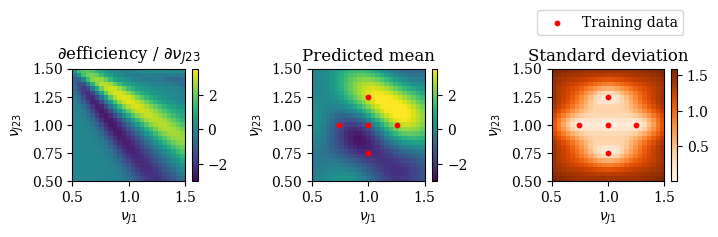

In [7]:
# -- Predicting the gradients with respect to the second derivative -------- #
dy_pred_mean_J23 = dy_pred_mean[n_test:]
dy_pred_std_J23 = dy_pred_std[n_test:]

print("\nEvaluation ")
mse = np.sum((dy_test[:, 1] - dy_pred_mean_J23.ravel()) ** 2) / n_test
print("MSE: ", mse)
print("Net variance: ", np.sum(dy_pred_std_J23**2))
# -------------------------------------------------------------------------- #

# -- Plotting -------------------------------------------------------------- #
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"

fig, ax = plt.subplots(1, 3, figsize=(8, 2))
plt.subplots_adjust(wspace=0.7)

im0 = ax[0].imshow(
    dy_test[:, 1].reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=-3,
    vmax=3.5,
)
fig.colorbar(im0, ax=ax[0], shrink=0.73)
ax[0].set_title("$\partial$efficiency / $\partial \\nu_{J23}$")
ax[0].set_xlabel(r"$\nu_{J1}$")
ax[0].set_ylabel(r"$\nu_{J23}$")

im1 = ax[1].imshow(
    dy_pred_mean_J23.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=-3,
    vmax=3.5,
)
fig.colorbar(im1, ax=ax[1], shrink=0.73)
ax[1].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10, label="Training data")
ax[1].set_title("Predicted mean")
ax[1].set_xlabel(r"$\nu_{J1}$")
ax[1].set_ylabel(r"$\nu_{J23}$")

im2 = ax[2].imshow(
    dy_pred_std_J23.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    cmap="Oranges",
)
fig.colorbar(im2, ax=ax[2], shrink=0.73)
ax[2].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10)
ax[2].set_title("Standard deviation")
ax[2].set_xlabel(r"$\nu_{J1}$")
ax[2].set_ylabel(r"$\nu_{J23}$")

ax[1].legend(loc=(2, 1.3))
plt.show()
# -------------------------------------------------------------------------- #

## Using only SOME gradients in the GP model


If, for example, only the gradients with respect to $\nu_{J23}$ are observed, 
we can still use them to enhance the GP model by specifying the index of the gradients in the idx parameter.

Kernel hyperparameters: 
0.488**2 * DerivativeRBF(length_scale=0.27) + WhiteKernel(noise_level=0.109) + WhiteKernel_der(noise_level=0.01)

Evaluation 
MSE:  0.07919749870156335
Net variance:  40.04471937373002


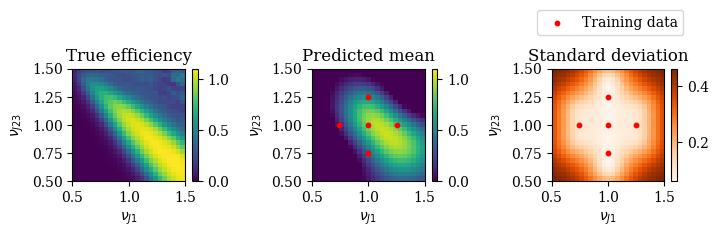

In [8]:
# -- Fitting the model and hyperparameter optimization --------------------- #
# Set optimizer=None to skip optimization
gp_onegrad = GaussianProcessRegressor(
    kernel=gp.kernel, optimizer=None, n_restarts_optimizer=10, random_state=42
)
gp_onegrad.fit(X_train, y_train, X_train, dy_train[:, 1], idx=[1])
print("Kernel hyperparameters: ")
print(gp_onegrad.kernel)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
y_pred_mean, y_pred_std = gp_onegrad.predict(X_test, return_std=True)

print("\nEvaluation ")
n_test = len(y_test)
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / n_test
print("MSE: ", mse)
print("Net variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #

# -- Plotting -------------------------------------------------------------- #
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"

fig, ax = plt.subplots(1, 3, figsize=(8, 2))
plt.subplots_adjust(wspace=0.7)

im0 = ax[0].imshow(
    y_test.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=0.0,
    vmax=1.1,
)
fig.colorbar(im0, ax=ax[0], shrink=0.73)
ax[0].set_title("True efficiency")
ax[0].set_xlabel(r"$\nu_{J1}$")
ax[0].set_ylabel(r"$\nu_{J23}$")

im1 = ax[1].imshow(
    y_pred_mean.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    vmin=0.0,
    vmax=1.1,
)
fig.colorbar(im1, ax=ax[1], shrink=0.73)
ax[1].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10, label="Training data")
ax[1].set_title("Predicted mean")
ax[1].set_xlabel(r"$\nu_{J1}$")
ax[1].set_ylabel(r"$\nu_{J23}$")

im2 = ax[2].imshow(
    y_pred_std.reshape(res_test, res_test),
    origin="upper",
    extent=(X_lower, X_upper, X_lower, X_upper),
    cmap="Oranges",
)
fig.colorbar(im2, ax=ax[2], shrink=0.73)
ax[2].scatter(X_train[:, 0], X_train[:, 1], color="r", s=10)
ax[2].set_title("Standard deviation")
ax[2].set_xlabel(r"$\nu_{J1}$")
ax[2].set_ylabel(r"$\nu_{J23}$")

ax[1].legend(loc=(2, 1.3))
plt.show()
# -------------------------------------------------------------------------- #

The prediction is slightly worse than when using all gradients, but still better than the regular GP prediction.